# Introduction

In this notebook I attempt to model `profit_per_transaction` with the given set of explanatory variables. Data Cleaning and Exploratory Data Analysis were done in `EDA.Rmd`. Unfortunately, the predictors at the hand aren't really usefull explaning the response variable I created. However, I still think that these models can help us identify some of the potential high value customers.

In [154]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor

plt.rcParams["figure.figsize"] = (9,9)
plt.rcParams["font.size"] = 14

In [156]:
customers = pd.read_csv("customer_all.csv")

# Variables

Numeric variables were useless as expected. Everytime I tried to model with them the model had gotten worse so I only modelled with categorical variables `"gender", "wealth_segment", "owns_car", "state", "diverging_job_title", "diverging_post_code"`.

In [157]:
y = customers.profit_per_transaction.values

scale_y = StandardScaler()

y = scale_y.fit_transform(y.reshape(-1,1)).flatten()

customers["scaled_y"] = y

In [158]:
x_num = customers[["age", "property_valuation"]].values

scale_x = StandardScaler()

x_num = scale_x.fit_transform(x_num)


In [159]:
onehot = OneHotEncoder()

x_cat = onehot.fit_transform(customers[["gender", "wealth_segment", "owns_car", "state", "diverging_job_title", "diverging_post_code"]]).toarray()

In [160]:
onehot2 = OneHotEncoder()

x_cat_jobs = onehot2.fit_transform(customers.job_title.values.reshape(-1,1)).toarray()

In [161]:
x_all = np.concatenate([x_num, x_cat], axis = 1)

In [162]:
x_all.shape, x_cat.shape

((3413, 50), (3413, 48))

# Modeling

I tried 4 models and the best performing one was Radial Support Vector Machines. However, I wanted to build an ensemble of models so at the end I naively averaged the predictions of all models.

The Predictor variables really aren't strong and because of it we can observe negative $R^2$ values. I didn't use train-test sets either because the data I was given was so small. I only used 5-Fold Cross Validation.

## MLP

In [163]:
mlp = MLPRegressor(max_iter=900, n_iter_no_change=20)

param_grid = [
    {"hidden_layer_sizes" : [5, 10, 20, 30, 50, 100], "alpha" : [0.9, 0.99, 1.2]}
]

scores_mlp = GridSearchCV(mlp, param_grid=param_grid, cv = 5, refit = True, verbose=3,
                     scoring="r2", n_jobs=4)

scores_mlp.fit(x_cat, y)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5, estimator=MLPRegressor(max_iter=900, n_iter_no_change=20),
             n_jobs=4,
             param_grid=[{'alpha': [0.9, 0.99, 1.2],
                          'hidden_layer_sizes': [5, 10, 20, 30, 50, 100]}],
             scoring='r2', verbose=3)

In [267]:
pd.DataFrame(scores_mlp.cv_results_).sort_values("rank_test_score").head().T

,7,3,0,14,16
mean_fit_time,1.006125,1.533112,1.047106,1.421658,1.697825
std_fit_time,0.195504,0.155025,0.221131,0.28442,0.24881
mean_score_time,0.0002,0.0008,0.001001,0.0004,0.000801
std_score_time,0.0004,0.0004,0.000001,0.00049,0.0004
param_alpha,0.99,0.9,0.9,1.2,1.2
param_hidden_layer_sizes,10,30,5,20,50
params,"{'alpha': 0.99, 'hidden_layer_sizes': 10}","{'alpha': 0.9, 'hidden_layer_sizes': 30}","{'alpha': 0.9, 'hidden_layer_sizes': 5}","{'alpha': 1.2, 'hidden_layer_sizes': 20}","{'alpha': 1.2, 'hidden_layer_sizes': 50}"
split0_test_score,-0.030157,-0.025012,-0.040022,-0.03443,-0.035129
split1_test_score,-0.028079,-0.019123,-0.022294,-0.016785,-0.026351
split2_test_score,-0.08729,-0.098147,-0.09855,-0.1066,-0.096705


Here I plotted fitted variables versus actual variables. What I want to see is that as the predictions increase so do the actual values. If they move together we can claim that at least we can identify potential high value customers. Since under-prediction is not going to be an issue for this business problem I tilted the upper interval line further. Two lines divide the plot into 4 pieces. Upward-Right section is where we are targetting for high value customers. 

Also, with a perfect model every observation would follow the solid red line.

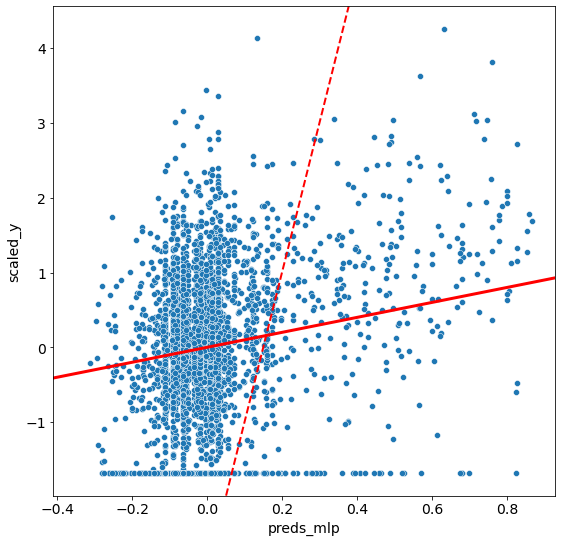

In [288]:
customers["preds_mlp"] = scores_mlp.predict(x_cat)

sns.scatterplot(x = "preds_mlp", y = "scaled_y", data = customers)
plt.axline([-0.35,-0.35], slope =1 , c = "red", linewidth = 3)

plt.axline([0.2,1], slope = 20 , c = "red", linestyle = "--", linewidth = 2)


## Gradient Boosting

In [326]:
xgb = GradientBoostingRegressor()

param_grid = [
    {"learning_rate" : [0.01, 0.05], "n_estimators" : [250, 500, 600, 700],
    "max_depth" : [2, 3]}
]

scores_xgb = GridSearchCV(xgb, param_grid=param_grid, cv = 5, refit=True, verbose=3,
                     scoring="r2", n_jobs=4)

scores_xgb.fit(x_cat, y)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=4,
             param_grid=[{'learning_rate': [0.005, 0.01, 0.05],
                          'max_depth': [2, 3, 5, 10],
                          'n_estimators': [250, 500, 600, 700]}],
             scoring='r2', verbose=3)

In [327]:
pd.DataFrame(scores_xgb.cv_results_).sort_values("rank_test_score").head().T

,19,32,18,17,3
mean_fit_time,1.080906,0.370587,0.88,0.739906,1.03891
std_fit_time,0.039619,0.00967,0.011102,0.010357,0.021416
mean_score_time,0.0036,0.001597,0.0028,0.002202,0.003195
std_score_time,0.001214,0.000491,0.0004,0.000399,0.00116
param_learning_rate,0.01,0.05,0.01,0.01,0.005
param_max_depth,2,2,2,2,2
param_n_estimators,700,250,600,500,700
params,"{'learning_rate': 0.01, 'max_depth': 2, 'n_est...","{'learning_rate': 0.05, 'max_depth': 2, 'n_est...","{'learning_rate': 0.01, 'max_depth': 2, 'n_est...","{'learning_rate': 0.01, 'max_depth': 2, 'n_est...","{'learning_rate': 0.005, 'max_depth': 2, 'n_es..."
split0_test_score,-0.046416,-0.04146,-0.048986,-0.051296,-0.05671
split1_test_score,-0.030471,-0.032152,-0.030744,-0.031816,-0.031112


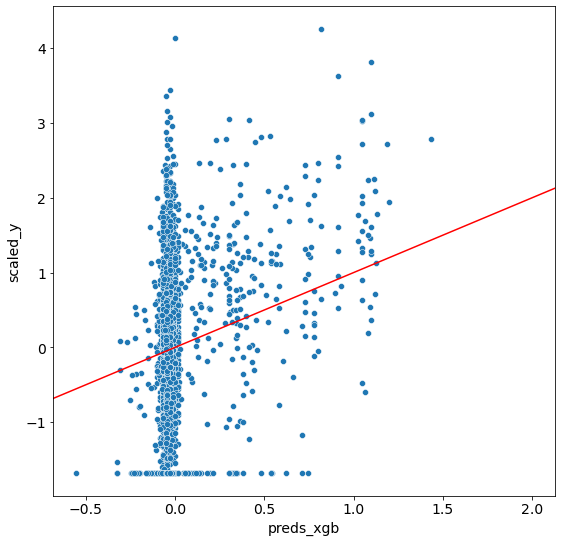

In [328]:
customers["preds_xgb"] = scores_xgb.predict(x_cat)

sns.scatterplot(x = "preds_xgb", y = "scaled_y", data = customers)
plt.axline([-0.5,-0.5], [2, 2], c = "red")

## SVM 

In [169]:
svm = SVR()

param_grid = [
    {"kernel" : ["rbf"], "C" : [0.1, 0.2, 0.3, 0.35, 0.4]}
]

scores_svm = GridSearchCV(svm, param_grid=param_grid, cv = 5, refit = True, verbose=3,
                     scoring="r2", n_jobs=4)

scores_svm.fit(x_cat,y)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=5, estimator=SVR(), n_jobs=4,
             param_grid=[{'C': [0.1, 0.2, 0.3, 0.35, 0.4], 'kernel': ['rbf']}],
             scoring='r2', verbose=3)

In [270]:
pd.DataFrame(scores_svm.cv_results_).sort_values("rank_test_score").head().T

,4,3,2,1,0
mean_fit_time,0.393343,0.507306,0.457876,0.405195,0.395097
std_fit_time,0.024381,0.032753,0.011675,0.02963,0.00423
mean_score_time,0.188895,0.213008,0.292661,0.220735,0.204357
std_score_time,0.027725,0.060579,0.060413,0.027275,0.011392
param_C,0.4,0.35,0.3,0.2,0.1
param_kernel,rbf,rbf,rbf,rbf,rbf
params,"{'C': 0.4, 'kernel': 'rbf'}","{'C': 0.35, 'kernel': 'rbf'}","{'C': 0.3, 'kernel': 'rbf'}","{'C': 0.2, 'kernel': 'rbf'}","{'C': 0.1, 'kernel': 'rbf'}"
split0_test_score,-0.008132,-0.011818,-0.01711,-0.02648,-0.051945
split1_test_score,0.001628,0.001786,0.002588,-0.00504,-0.020407
split2_test_score,-0.072188,-0.071443,-0.070459,-0.078089,-0.086683


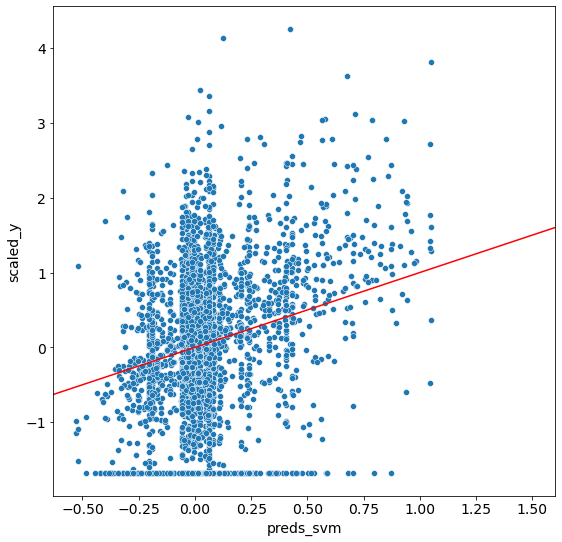

In [171]:
customers["preds_svm"] = scores_svm.predict(x_cat)

sns.scatterplot(x = "preds_svm", y = "scaled_y", data = customers)
plt.axline([-0.5,-0.5], [1.5, 1.5], c = "red")

## RF

In [309]:
rf = RandomForestRegressor()

param_grid = [
    {"n_estimators" : [100, 300, 600, 900], "max_features" : [1,2,3, "auto"]}
]

scores_rf = GridSearchCV(rf, param_grid=param_grid, cv = 5, refit = True, verbose=3,
                     scoring="r2", n_jobs=4)

scores_rf.fit(x_cat,y)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=4,
             param_grid=[{'max_features': [1, 2, 3, 'auto'],
                          'n_estimators': [100, 300, 600, 900]}],
             scoring='r2', verbose=3)

In [310]:
pd.DataFrame(scores_rf.cv_results_).sort_values("rank_test_score").head().T

,9,11,7,10,6
mean_fit_time,0.597223,1.715188,1.657131,1.153727,1.144764
std_fit_time,0.018114,0.023485,0.026405,0.01909,0.018748
mean_score_time,0.038199,0.111139,0.111534,0.07475,0.081401
std_score_time,0.000398,0.002225,0.00241,0.001534,0.008163
param_max_features,3,3,2,3,2
param_n_estimators,300,900,900,600,600
params,"{'max_features': 3, 'n_estimators': 300}","{'max_features': 3, 'n_estimators': 900}","{'max_features': 2, 'n_estimators': 900}","{'max_features': 3, 'n_estimators': 600}","{'max_features': 2, 'n_estimators': 600}"
split0_test_score,-0.149587,-0.149759,-0.148923,-0.150364,-0.148672
split1_test_score,-0.108419,-0.109752,-0.109918,-0.107607,-0.114475
split2_test_score,-0.240429,-0.241345,-0.244894,-0.243149,-0.246326


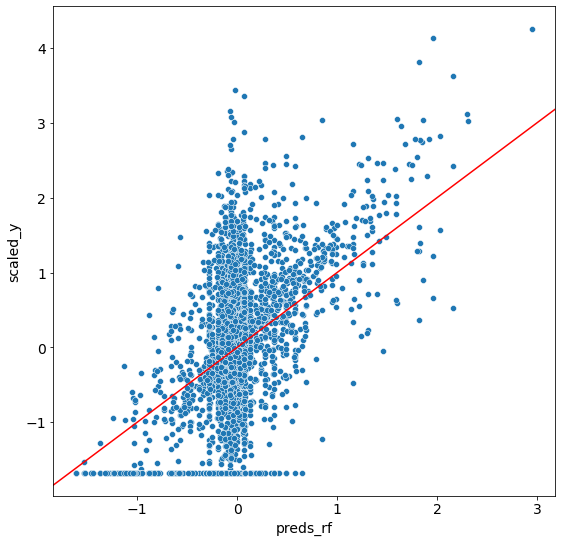

In [311]:
customers["preds_rf"] = scores_rf.predict(x_cat)

sns.scatterplot(x = "preds_rf", y = "scaled_y", data = customers)
plt.axline([-0.5,-0.5], [2, 2], c = "red")

## Ensemble Models

In [312]:
customers["ensemble"] = (customers.preds_rf + customers.preds_svm + customers.preds_xgb + customers.preds_mlp) / 4

In [313]:
customers["ensemble_T"] = scale_y.inverse_transform(customers.ensemble.values.reshape(-1,1)).flatten()

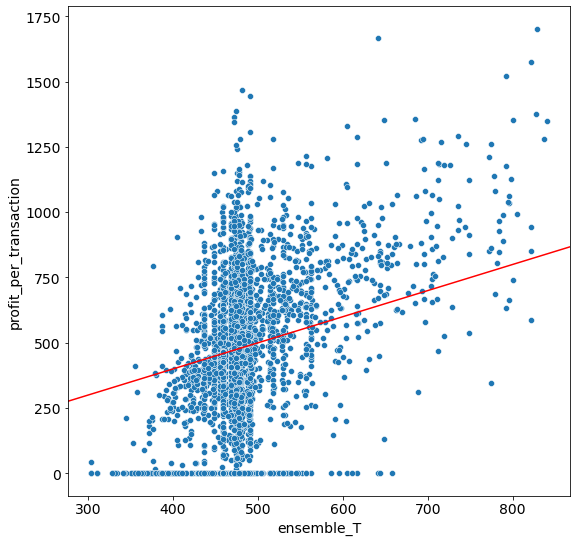

In [314]:
sns.scatterplot(x = "ensemble_T", y = "profit_per_transaction", data = customers)
plt.axline([400,400], [800, 800], c = "red")

# Getting prediction from the New Customer Data 

Let's get predictions from the new data and try to understand where our models lead us.

In [315]:
new_customers = pd.read_csv("new_customers.csv")

In [316]:
onehot_pred = OneHotEncoder()

new_x_cat = onehot_pred.fit_transform(new_customers[["gender", "wealth_segment", "owns_car", "state", "diverging_job_title", "diverging_post_code"]]).toarray()

In [317]:
new_x_cat.shape

(878, 48)

In [318]:
new_customers["preds_svm"] = scores_svm.predict(new_x_cat)
new_customers["preds_xgb"] = scores_xgb.predict(new_x_cat)
new_customers["preds_rf"] = scores_rf.predict(new_x_cat)

In [319]:
new_customers["ensemble"] = (new_customers.preds_rf + new_customers.preds_svm + new_customers.preds_xgb) / 3

In [320]:
new_customers["ensemble_T"] = scale_y.inverse_transform(new_customers.ensemble.values.reshape(-1,1)).flatten()

## Visualizing Predictions versus Predictors

<AxesSubplot:xlabel='ensemble_T', ylabel='diverging_job_title'>

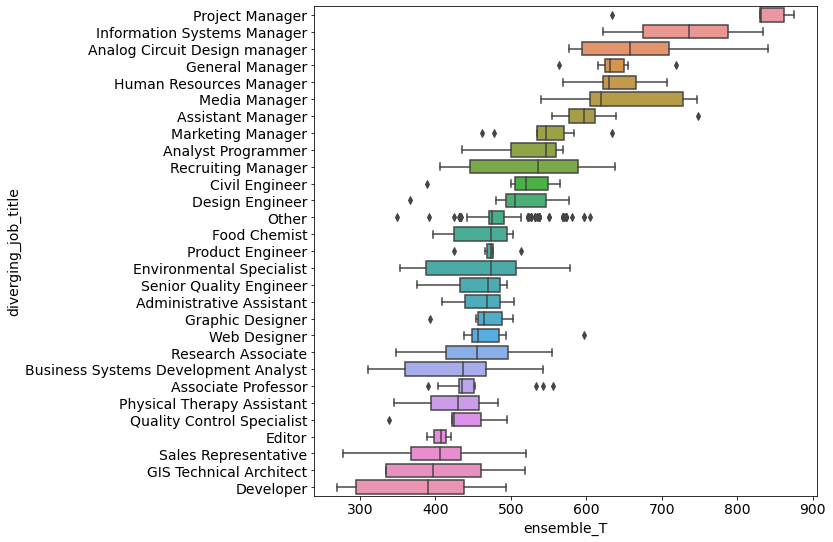

In [321]:
sort_order = new_customers[["ensemble_T","diverging_job_title"]].groupby("diverging_job_title").median().sort_values("ensemble_T", ascending=False).index

sns.boxplot(x = "ensemble_T", y = "diverging_job_title", data = new_customers, order = sort_order)

<AxesSubplot:xlabel='ensemble_T', ylabel='diverging_post_code'>

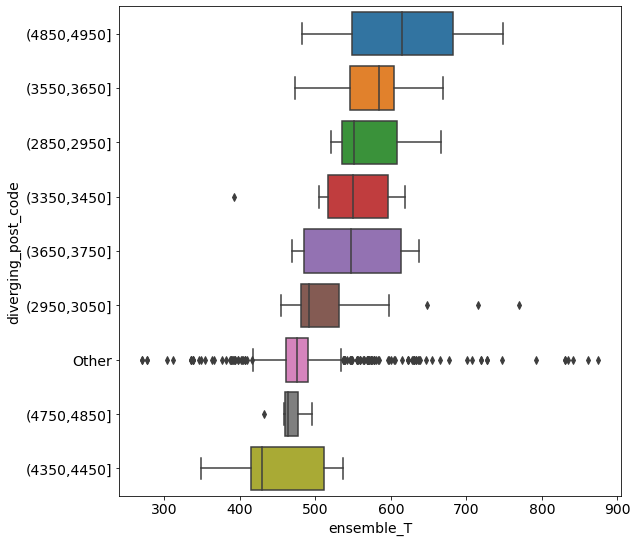

In [322]:
sort_order = new_customers[["ensemble_T","diverging_post_code"]].groupby("diverging_post_code").median().sort_values("ensemble_T", ascending=False).index

sns.boxplot(x = "ensemble_T", y = "diverging_post_code", data = new_customers, order = sort_order)

<AxesSubplot:xlabel='ensemble_T', ylabel='gender'>

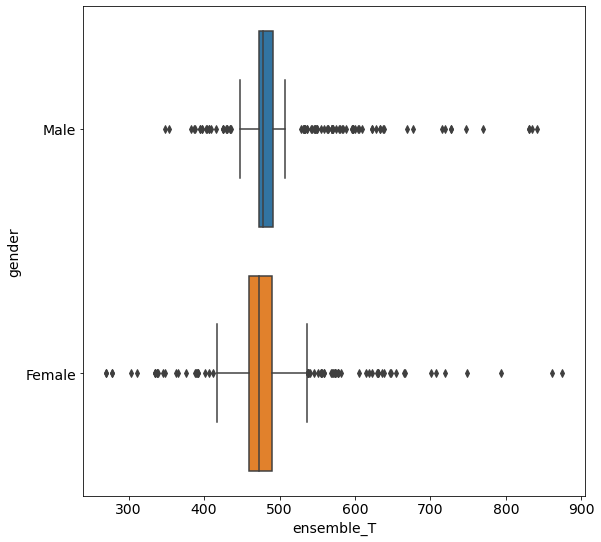

In [323]:
sort_order = new_customers[["ensemble_T","gender"]].groupby("gender").median().sort_values("ensemble_T", ascending=False).index

sns.boxplot(x = "ensemble_T", y = "gender", data = new_customers, order = sort_order)

<AxesSubplot:xlabel='ensemble_T', ylabel='owns_car'>

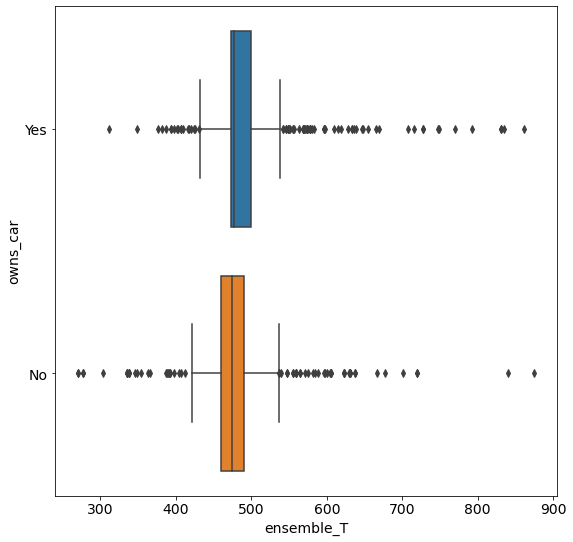

In [324]:
sort_order = new_customers[["ensemble_T","owns_car"]].groupby("owns_car").median().sort_values("ensemble_T", ascending=False).index

sns.boxplot(x = "ensemble_T", y = "owns_car", data = new_customers, order = sort_order)

<AxesSubplot:xlabel='ensemble_T', ylabel='state'>

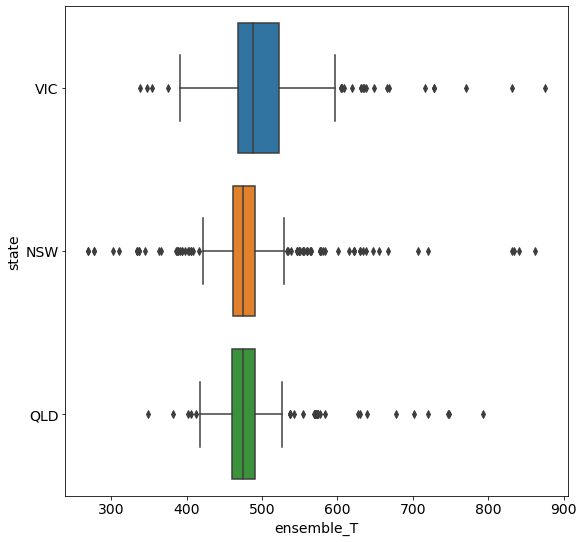

In [325]:
sort_order = new_customers[["ensemble_T","state"]].groupby("state").median().sort_values("ensemble_T", ascending=False).index

sns.boxplot(x = "ensemble_T", y = "state", data = new_customers, order = sort_order)